# Homework 2: Mining Time Series 
### Do the top 5 countries with the most cumulative COVID-19 cases demonstrate similar patterns?


* we are interested in the number of daily new cases exclusively from the top 5 countries that have the most cumulative cases as of August 21, 2020.
* To explore and analyze this dataset, this assignment will focus on extracting the seasonal component from the countries' time series, computing the similarity between them, and calculating the Dynamic Time Warping (DTW) Cost.

In [65]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
import math


# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

## Part 1: Load & Transform the Data




#### a) 


In [12]:
def load_data():
    
    # filter only the needed data
    data = pd.read_csv('time_series_covid19_confirmed_global.csv').set_index('Country/Region')
    data = data.filter(regex=r"[0-9]+/[0-9]+/[0-9]+", axis="columns")
    
    # find top 5
    top_5 = data.loc[data['8/21/20'].sort_values(ascending=False)[:5].index]
    top_5_trans = top_5.T
    
    # datetime format
    top_5_trans.index = pd.to_datetime(top_5_trans.index, infer_datetime_format=True)
    
    # new cases
    top_5_new = top_5_trans.diff()
    
    # drop NAN
    top_5_new.dropna(inplace=True)
    
    return top_5_new

load_data()

Country/Region,US,Brazil,India,Russia,South Africa
2020-01-23,0.0,0.0,0.0,0.0,0.0
2020-01-24,1.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0
2020-01-26,3.0,0.0,0.0,0.0,0.0
2020-01-27,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2020-08-17,35112.0,19373.0,55018.0,4839.0,2541.0
2020-08-18,44091.0,47784.0,64572.0,4718.0,2258.0
2020-08-19,47408.0,49298.0,69672.0,4790.0,3916.0
2020-08-20,44023.0,45323.0,68900.0,4767.0,3880.0


In [13]:
top_5_daily = load_data()
top_5_daily

Country/Region,US,Brazil,India,Russia,South Africa
2020-01-23,0.0,0.0,0.0,0.0,0.0
2020-01-24,1.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0
2020-01-26,3.0,0.0,0.0,0.0,0.0
2020-01-27,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2020-08-17,35112.0,19373.0,55018.0,4839.0,2541.0
2020-08-18,44091.0,47784.0,64572.0,4718.0,2258.0
2020-08-19,47408.0,49298.0,69672.0,4790.0,3916.0
2020-08-20,44023.0,45323.0,68900.0,4767.0,3880.0


In [14]:
top_5_daily.index

DatetimeIndex(['2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26',
               '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30',
               '2020-01-31', '2020-02-01',
               ...
               '2020-08-12', '2020-08-13', '2020-08-14', '2020-08-15',
               '2020-08-16', '2020-08-17', '2020-08-18', '2020-08-19',
               '2020-08-20', '2020-08-21'],
              dtype='datetime64[ns]', length=212, freq=None)

In [21]:
isinstance(top_5_daily.index, pd.DatetimeIndex)

True

In [16]:
top_5_daily.isna().any()

Country/Region
US              False
Brazil          False
India           False
Russia          False
South Africa    False
dtype: bool

In [18]:
top_5_daily.values

array([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       ...,
       [4.7408e+04, 4.9298e+04, 6.9672e+04, 4.7900e+03, 3.9160e+03],
       [4.4023e+04, 4.5323e+04, 6.8900e+04, 4.7670e+03, 3.8800e+03],
       [4.8693e+04, 3.0355e+04, 6.9876e+04, 4.8380e+03, 3.3980e+03]])

#### b)

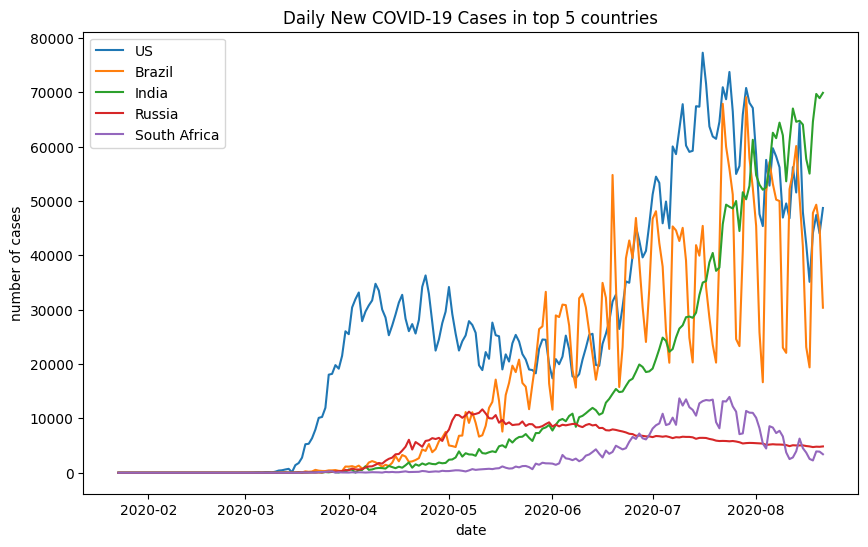

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(top_5_daily)
ax.set_xlabel("date")
ax.set_ylabel("number of cases")
ax.set_title("Daily New COVID-19 Cases in top 5 countries")
ax.legend(top_5_daily.columns)

## Part 2: Extract Seasonal Components

#### a)

In [41]:
def sea_decomp(df):
    
    col_seasonal = {}
    for col in df.columns:
        col_seasonal[col] = seasonal_decompose(df[col], model="additive").seasonal
    
    seasonal_comp = pd.DataFrame(col_seasonal)
    
    return seasonal_comp

sea_decomp(top_5_daily)    

,US,Brazil,India,Russia,South Africa
2020-01-23,2431.761670,3380.626554,441.179428,-54.886371,322.986535
2020-01-24,3446.796153,3457.641332,621.396176,23.689984,362.434811
2020-01-25,578.564626,586.665963,594.066127,55.034811,391.346141
2020-01-26,-2728.454422,-6031.950950,46.655454,137.908703,76.880131
2020-01-27,-3293.854422,-7144.674760,-1234.673118,1.842036,-507.496059
...,...,...,...,...,...
2020-08-17,-3293.854422,-7144.674760,-1234.673118,1.842036,-507.496059
2020-08-18,-719.521088,1549.577621,-544.749308,-28.929392,-662.877011
2020-08-19,284.707483,4202.114239,76.125240,-134.659770,16.725452
2020-08-20,2431.761670,3380.626554,441.179428,-54.886371,322.986535


In [43]:
top_5_daily_seasonal = sea_decomp(top_5_daily)  

isinstance(top_5_daily_seasonal.index, pd.DatetimeIndex)

True

In [44]:
top_5_daily_seasonal.isna().any()

US              False
Brazil          False
India           False
Russia          False
South Africa    False
dtype: bool

#### b)

Text(0.513, 0.95, 'Daily New COVID-19 Cases in top 5 countries_seasonal component')

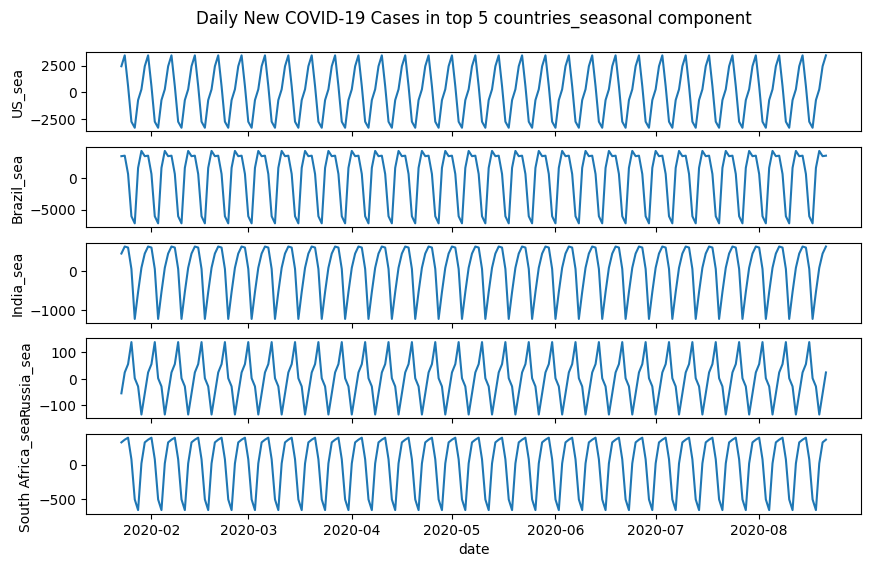

In [54]:
fig, axes = plt.subplots(5, 1, figsize=(10, 6), sharex=True)

for i, col in enumerate(top_5_daily_seasonal.columns):
    
    axes[i].plot(top_5_daily_seasonal[col])
    axes[i].set_ylabel(col+"_sea")
    
axes[4].set_xlabel("date")
fig.suptitle("Daily New COVID-19 Cases in top 5 countries_seasonal component", x=0.513, y=0.95)

## Part 3: Time Series Similarities

### 3.1 Euclidean Distance

#### a)

In [55]:
top_5_daily

Country/Region,US,Brazil,India,Russia,South Africa
2020-01-23,0.0,0.0,0.0,0.0,0.0
2020-01-24,1.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0
2020-01-26,3.0,0.0,0.0,0.0,0.0
2020-01-27,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2020-08-17,35112.0,19373.0,55018.0,4839.0,2541.0
2020-08-18,44091.0,47784.0,64572.0,4718.0,2258.0
2020-08-19,47408.0,49298.0,69672.0,4790.0,3916.0
2020-08-20,44023.0,45323.0,68900.0,4767.0,3880.0


In [62]:
def calc_euclidean_dist(df):
    
    # create the output df
    euclidean_df = pd.DataFrame(0, index=df.columns, columns=df.columns)
    
    # calculate euclidean distance
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            euclidean_df.loc[df.columns[i], df.columns[j]] = np.sqrt(np.sum(np.square(df[df.columns[i]]-df[df.columns[j]])))
    
    return euclidean_df
    
calc_euclidean_dist(top_5_daily)

Country/Region,US,Brazil,India,Russia,South Africa
Country/Region,,,,,
US,0.000000,233760.757213,272344.138927,433638.331574,436238.175972
Brazil,233760.757213,0.000000,178779.663740,306032.283923,304919.698741
India,272344.138927,178779.663740,0.000000,316862.767630,303936.538967
Russia,433638.331574,306032.283923,316862.767630,0.000000,67392.593681
South Africa,436238.175972,304919.698741,303936.538967,67392.593681,0.000000


#### b)

In [63]:
top_5_daily_seasonal

,US,Brazil,India,Russia,South Africa
2020-01-23,2431.761670,3380.626554,441.179428,-54.886371,322.986535
2020-01-24,3446.796153,3457.641332,621.396176,23.689984,362.434811
2020-01-25,578.564626,586.665963,594.066127,55.034811,391.346141
2020-01-26,-2728.454422,-6031.950950,46.655454,137.908703,76.880131
2020-01-27,-3293.854422,-7144.674760,-1234.673118,1.842036,-507.496059
...,...,...,...,...,...
2020-08-17,-3293.854422,-7144.674760,-1234.673118,1.842036,-507.496059
2020-08-18,-719.521088,1549.577621,-544.749308,-28.929392,-662.877011
2020-08-19,284.707483,4202.114239,76.125240,-134.659770,16.725452
2020-08-20,2431.761670,3380.626554,441.179428,-54.886371,322.986535


In [64]:
calc_euclidean_dist(top_5_daily_seasonal)

,US,Brazil,India,Russia,South Africa
US,0.000000,37616.752035,27032.887714,33986.305519,30084.544171
Brazil,37616.752035,0.000000,57583.437987,63663.896821,60839.376478
India,27032.887714,57583.437987,0.000000,9102.412727,4490.020448
Russia,33986.305519,63663.896821,9102.412727,0.000000,5658.222387
South Africa,30084.544171,60839.376478,4490.020448,5658.222387,0.000000


#### 3.2 Cosine Similarity
#### a)

In [67]:
def calc_cos_sim(df):
    
    # create the output df
    cos_sim_df = pd.DataFrame(0, index=df.columns, columns=df.columns)
    
    # calculate cos_sim
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            a = df[df.columns[i]]
            b = df[df.columns[j]]
            cos_sim_df.loc[df.columns[i], df.columns[j]] = np.dot(a,b)/(norm(a)*norm(b))
    
    return cos_sim_df
    
calc_cos_sim(top_5_daily)

Country/Region,US,Brazil,India,Russia,South Africa
Country/Region,,,,,
US,1.000000,0.898664,0.847160,0.804740,0.884909
Brazil,0.898664,1.000000,0.878452,0.763523,0.871214
India,0.847160,0.878452,1.000000,0.590388,0.809944
Russia,0.804740,0.763523,0.590388,1.000000,0.638246
South Africa,0.884909,0.871214,0.809944,0.638246,1.000000


#### b)

In [68]:
calc_cos_sim(top_5_daily_seasonal)

,US,Brazil,India,Russia,South Africa
US,1.000000,0.868859,0.783851,-0.325065,0.664261
Brazil,0.868859,1.000000,0.632741,-0.629987,0.403198
India,0.783851,0.632741,1.000000,0.092292,0.917529
Russia,-0.325065,-0.629987,0.092292,1.000000,0.174437
South Africa,0.664261,0.403198,0.917529,0.174437,1.000000


## Part 4: Dynamic Time Warping (DTW) Cost

#### 4.1 Define a Function to Calculate DTW Cost
#### a)

In [89]:
def calc_pairwise_dtw_cost(x, y, ret_matrix=True):
    
    # length of 2 series
    n, m = len(x), len(y)
    # create zero marix
    dtw_matrix = np.zeros((n+1, m+1))
    
    # fill with inf (for len+1 df to list column names
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
            
    # fill the left top corner
    dtw_matrix[0, 0] = 0
    
    # fill values in the df 
    for i in range(1, n+1):
        for j in range(1, m+1):
            
            # d(xi, yj) = (xi - yj)^2 
            cost = np.square(y[i-1] - x[j-1])
            
            # the distance:dtw_matrix[i, j]
            dtw_matrix[i, j] = cost + np.min([dtw_matrix[i, j-1], dtw_matrix[i-1, j], dtw_matrix[i-1, j-1]])
   
    # if retain matrix         
    if ret_matrix:
        return dtw_matrix[1:, 1:]
        
    # if return the last element of the matrix, bottom-right corner
    return dtw_matrix[n,m]

In [94]:
# simple test

a = [1,2,3,4,5]
b = [2,2,2,3,4]

arr = calc_pairwise_dtw_cost(a,b, False)

In [95]:
arr

2.0

In [96]:
arr.shape

()

In [97]:
type(arr)

numpy.float64

#### 4.2 Compute Pairwise DTW Cost
#### a)

In [101]:
def calc_dtw_cost(df):
    
    # create the output df
    dtw_df = pd.DataFrame(0, index=df.columns, columns=df.columns)
    
    # calculate dtw
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            dtw_df.loc[df.columns[i], df.columns[j]] = calc_pairwise_dtw_cost(df[df.columns[i]], df[df.columns[j]], False)
    
    return dtw_df

In [102]:
calc_dtw_cost(top_5_daily)

Country/Region,US,Brazil,India,Russia,South Africa
Country/Region,,,,,
US,0,9575974038,5187397134,174074662446,139515939601
Brazil,9575974038,0,14309884215,83618108875,65427030728
India,5187397134,14309884215,0,99276257414,87289503477
Russia,174074662446,83618108875,99276257414,0,163867116
South Africa,139515939601,65427030728,87289503477,163867116,0


In [103]:
calc_dtw_cost(top_5_daily).shape

(5, 5)

#### b)

In [104]:
# seasonal data - dtw 

np.sqrt(calc_dtw_cost(top_5_daily_seasonal))

,US,Brazil,India,Russia,South Africa
US,0.000000,31878.178988,23565.948799,32327.414867,28016.515162
Brazil,31878.178988,0.000000,53400.789074,61868.013722,57143.198022
India,23565.948799,53400.789074,0.000000,7687.627537,4463.425362
Russia,32327.414867,61868.013722,7687.627537,0.000000,4259.096369
South Africa,28016.515162,57143.198022,4463.425362,4259.096369,0.000000


In [106]:
# seasonal data - euclidean

calc_euclidean_dist(top_5_daily_seasonal)

,US,Brazil,India,Russia,South Africa
US,0.000000,37616.752035,27032.887714,33986.305519,30084.544171
Brazil,37616.752035,0.000000,57583.437987,63663.896821,60839.376478
India,27032.887714,57583.437987,0.000000,9102.412727,4490.020448
Russia,33986.305519,63663.896821,9102.412727,0.000000,5658.222387
South Africa,30084.544171,60839.376478,4490.020448,5658.222387,0.000000


In [107]:
# seasonal data - cos similarity

calc_cos_sim(top_5_daily_seasonal)

,US,Brazil,India,Russia,South Africa
US,1.000000,0.868859,0.783851,-0.325065,0.664261
Brazil,0.868859,1.000000,0.632741,-0.629987,0.403198
India,0.783851,0.632741,1.000000,0.092292,0.917529
Russia,-0.325065,-0.629987,0.092292,1.000000,0.174437
South Africa,0.664261,0.403198,0.917529,0.174437,1.000000


* What can you say about the similarities among these seasonal patterns? Do the results
of the pairwise Euclidean Distance, Cosine Similarity and DTW Cost calculations tell the
same story?

1. About these seasonal patterns, (based on cos similarity) Take the US for example, the US has a relatively high similarity with Brazil and India, an average similarity with South Africa, and a negative correlation with Russia. The correlation between Russia and other countries is very low. The highest similarity is between South Africa and India.

2. (Based on Euclidean Distance and DTW Cost), the lowest similarity is with Russia and Brazil, and the highest similarity is with (South Africa, India) (South Africa, Russia). 

3. for most of the results, the pairwise Euclidean Distance and DTW Cost and some cos similirity have the similar pattern/ tell the same story, but Cosine Similarity do show some contradictory patterns, (i.e., for US and Brazil, the Euclidean Distance and DTW Cost are high, but the Cos similarity is also high.)